# Iterative Construction of a Penalised Vine Structure
This notebook iteratively estimate the quantile.

#### Libraries

In [1]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

random_state = 123
np.random.seed(random_state)

#### Model function
This example consider the simple additive example.

In [2]:
from dependence.tests import func_overflow, margins_overflow, var_names_overflow, func_sum
from dependence.tests.test_functions import func_prod
from dependence import iterative_vine_minimize

test_func = func_sum

#### Dimension and margins
We first define the problem dimension and the margins

In [3]:
if test_func == func_overflow:
    margins = margins_overflow
    dim = len(margins)
else:
    dim = 8
    margins = [ot.Normal()]*dim

We chose the coefficients of the variables throught the additive function.

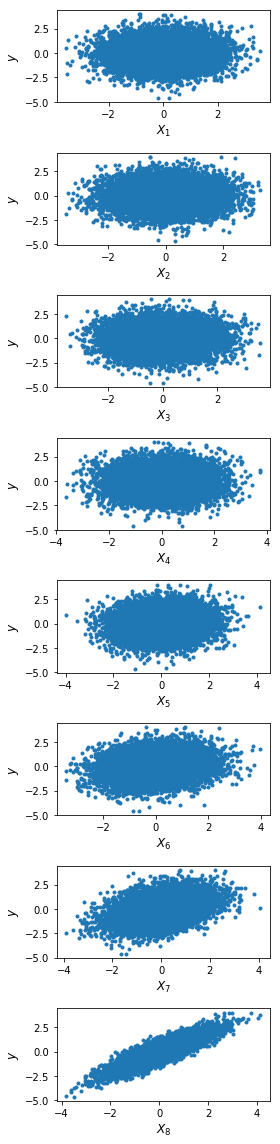

In [4]:
if test_func in [func_sum, func_prod]:
    coeficients = np.logspace(0., 3., dim+1, endpoint=False)[1:]
    coeficients /= coeficients.max()
    #coeficients = np.asarray(range(dim))
    new_test_func = lambda x: test_func(x, coeficients)

    n_plot = 10000
    x = np.asarray(ot.ComposedDistribution(margins).getSample(n_plot))
    y = test_func(x, coeficients)    

    fig, axes = plt.subplots(dim, 1, sharex=False, sharey=True, figsize=(4, 2*dim))
    for i in range(dim):
        ax = axes[i]
        ax.plot(x[:, i], y, '.')
        ax.set_xlabel(r'$X_{%d}$' % (i+1), fontsize=12)
        ax.set_ylabel(r'$y$', fontsize=12)
    fig.tight_layout()
else:
    new_test_func = test_func

#### Copula families
We now consider only Gaussian dependencies for this example

In [5]:
families = np.zeros((dim, dim), dtype=int)
for i in range(1, dim):
    for j in range(i):
        families[i, j] = 1

## Estimations
We create an instance of the main class for conservative estimate, and we define a q_func object for the quantile as a quantity of interest

In [6]:
from dependence import ConservativeEstimate, quantile_func

alpha = 0.95

if alpha > 0.5: # Maximizing the quantile
    def q_func(x, axis=1):
        return - quantile_func(alpha)(x, axis=axis)
else: # Minimizing
    q_func = quantile_func(alpha)

quant_estimate = ConservativeEstimate(model_func=new_test_func, margins=margins, families=families)

First, we compute the quantile at independence

In [7]:
n = 10000
indep_result = quant_estimate.independence(n_input_sample=n, q_func=q_func, random_state=random_state)

In [8]:
indep_result.compute_bootstrap(1000)
boot_std = indep_result.bootstrap_sample.std()
boot_mean = indep_result.bootstrap_sample.mean()
print('Quantile at independence: %.2f with a C.O.V at %.1f %%' % (boot_mean, abs(boot_std/boot_mean)*100.))

Quantile at independence: -1.86 with a C.O.V at 1.4 %


In [215]:
algorithm_parameters = {
    "n_input_sample": 10000,
    "n_dep_param_init": 10,
    "max_n_pairs": 1,
    "grid_type": 'lhs',
    "q_func": q_func,
    "n_add_pairs": 1,
    "n_remove_pairs": 0,
    "adapt_vine_structure": True,
    "with_bootstrap": False,
    "verbose": False,
    "iterative_save": False,
    "iterative_load": False,
    "load_input_samples": False,
    "keep_input_samples": False
}

quant_estimate = ConservativeEstimate(model_func=new_test_func, margins=margins, families=families)

iterative_results = iterative_vine_minimize(estimate_object=quant_estimate, **algorithm_parameters)


Iteration 1: selected pair: (8, 7)
Total number of evaluations = 3600000. Minimum quantity at -2.50.

Max number of pairs reached


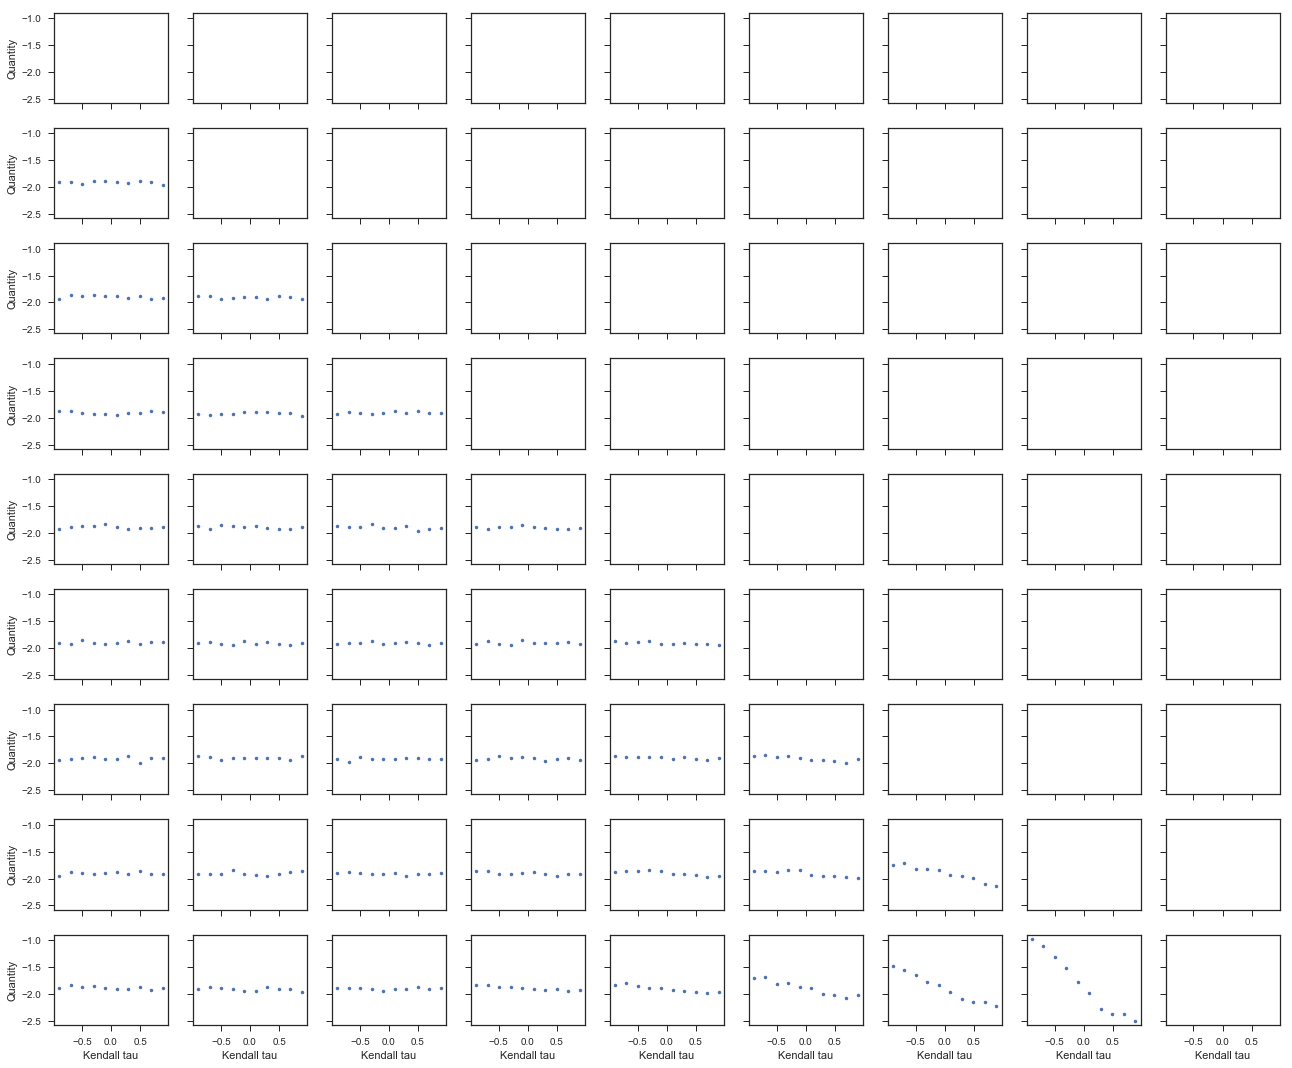

In [216]:
from dependence.dependence_plot import matrix_plot_quantities
results = iterative_results[0]
matrix_plot_quantities(results, figsize=(18, 15))
# plt.savefig('output/matrix_plot.png')

### Iterative Approach
Now lets see how good we can be with the iterative appraoch.

In [20]:
algorithm_parameters = {
    "n_input_sample": 10000,
    "n_dep_param_init": 20,
    "max_n_pairs": 3,
    "grid_type": 'vertices',
    "q_func": q_func,
    "n_add_pairs": 2,
    "n_remove_pairs": 7,
    "adapt_vine_structure": False,
    "with_bootstrap": False,
    "verbose": True,
    "iterative_save": False,
    "iterative_load": False,
    "load_input_samples": False,
    "keep_input_samples": False,
    "input_names": var_names_overflow
}

quant_estimate = ConservativeEstimate(model_func=new_test_func, margins=margins, families=families)

iterative_results = iterative_vine_minimize(estimate_object=quant_estimate, **algorithm_parameters)

n=10000. Worst quantile of [(1, 0)] at -1.8365542554541638
The variables are: K_s-Q
n=10000. Worst quantile of [(2, 0)] at -1.8245302264434484
The variables are: Z_v-Q
n=10000. Worst quantile of [(2, 1)] at -1.8658454406628129
The variables are: Z_v-K_s
n=10000. Worst quantile of [(3, 0)] at -1.8948356176617809
The variables are: Z_m-Q
n=10000. Worst quantile of [(3, 1)] at -1.8897021464935606
The variables are: Z_m-K_s
n=10000. Worst quantile of [(3, 2)] at -1.8746482861346154
The variables are: Z_m-Z_v
n=10000. Worst quantile of [(4, 0)] at -1.8692452915370747
The variables are: H_d-Q
n=10000. Worst quantile of [(4, 1)] at -1.84057992389644
The variables are: H_d-K_s
n=10000. Worst quantile of [(4, 2)] at -1.8764223127288653
The variables are: H_d-Z_v
n=10000. Worst quantile of [(4, 3)] at -1.868190935451335
The variables are: H_d-Z_m
n=10000. Worst quantile of [(5, 0)] at -1.8704323637793827
The variables are: C_b-Q
n=10000. Worst quantile of [(5, 1)] at -1.8522220859479948
The vari

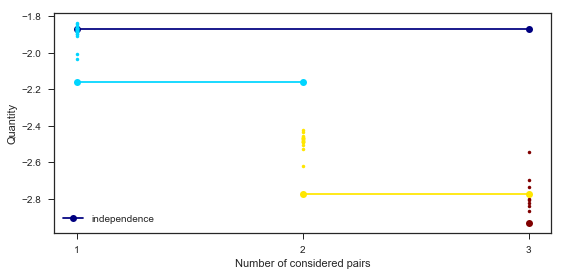

In [17]:
from dependence.dependence_plot import plot_iterative_results, matrix_plot_input

plot_iterative_results(iterative_results, indep_result=indep_result, q_func=q_func)

In [18]:
n = 10000
K = 300
quant_estimate.vine_structure = None
grid_results = quant_estimate.gridsearch(n_dep_param=K, n_input_sample=n, q_func=q_func, grid_type='vertices')

In [19]:
min_result = grid_results.min_result
print(min_result.quantity)

-3.0746765451805227


In [ ]:
from dependence.dependence_plot import matrix_plot_input
matrix_plot_input(min_result, margins=margins)

In [46]:
from dependence.utils import get_pair_id, get_pairs_by_levels, get_possible_structures
pairs_iter = [[1, 0]]
pairs_iter_id = [get_pair_id(dim, pair, with_plus=False) for pair in pairs_iter]
pairs_by_levels = get_pairs_by_levels(dim, pairs_iter_id)
quant_estimate.vine_structure = get_possible_structures(dim, pairs_by_levels)[0]
quant_estimate.vine_structure

array([[2, 0, 0, 0, 0, 0, 0, 0],
       [8, 1, 0, 0, 0, 0, 0, 0],
       [7, 8, 3, 0, 0, 0, 0, 0],
       [6, 7, 8, 4, 0, 0, 0, 0],
       [5, 6, 7, 8, 5, 0, 0, 0],
       [4, 5, 6, 7, 8, 6, 0, 0],
       [3, 4, 5, 6, 7, 8, 7, 0],
       [1, 3, 4, 5, 6, 7, 8, 8]])

In [47]:
grid_results = quant_estimate.gridsearch(n_dep_param=K, n_input_sample=n, q_func=q_func)

In [48]:
min_result = grid_results.min_result
print(min_result.quantity)

-0.5385555538636204


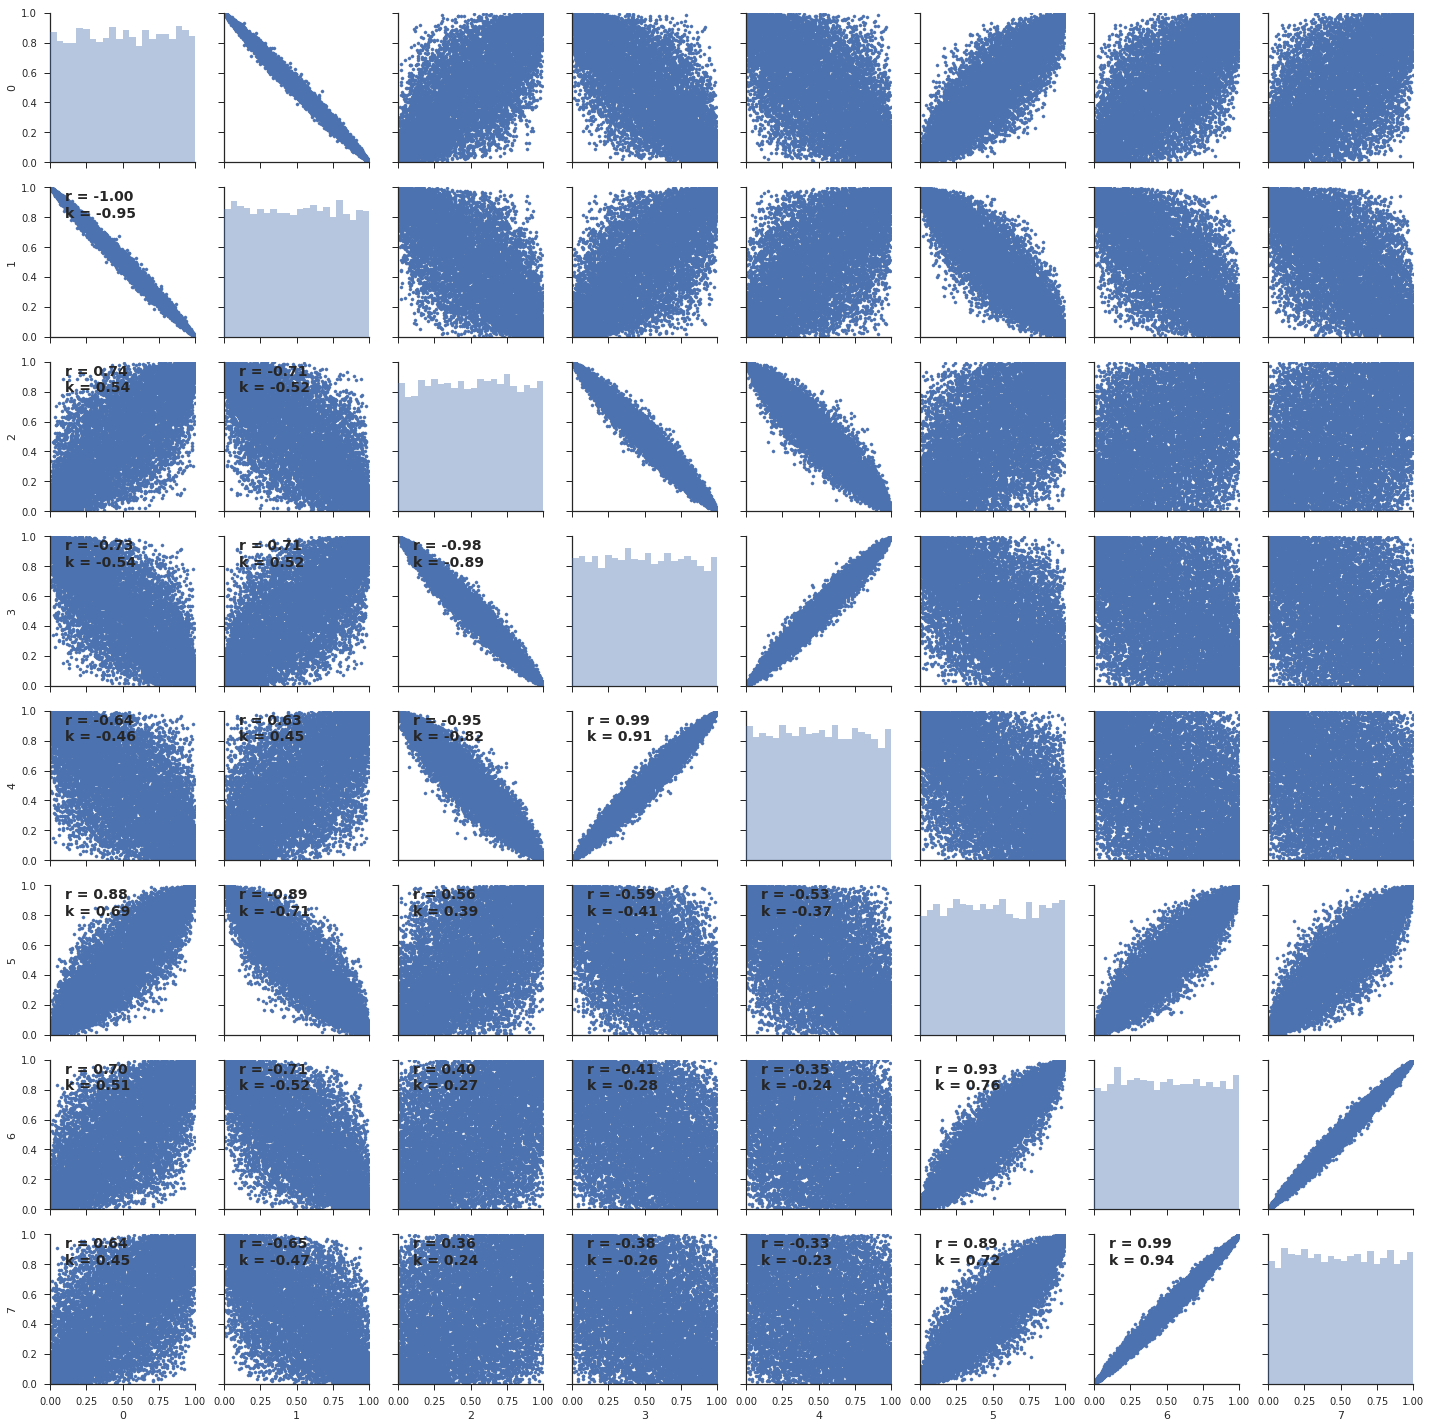

In [49]:
from dependence.dependence_plot import matrix_plot_input
matrix_plot_input(min_result, margins=margins)